In [1]:
import pandas as pd

In [2]:
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()

In [3]:
symbol = 'btc'

In [4]:
data = pd.read_pickle('data/stocktwits/datasets_clean/' + symbol + '_twits_012018_072019_clean.pickle')

In [198]:
bert_unb_sent = pd.read_pickle('data/stocktwits/bert_unb_sentiment/bert_unb_' + symbol + '_sentiment.pickle')

In [5]:
data.shape

(795170, 11)

In [200]:
bert_unb_sent.shape

(795170, 4)

In [201]:
data['calc_sent'] = bert_unb_sent.replace({'pred_label' : {'Negative' : 0, 'Positive': 1}}).pred_label

In [202]:
data.index = data.created_at

In [203]:
data = data.tz_convert('America/New_York')

In [204]:
data = data[data.index > pd.to_datetime('2018-07-01 04:00:00+00:00').tz_convert('America/New_York')]

In [230]:
price = data.price.groupby(data.index.date).last()

In [231]:
data['pos'] = (data.calc_sent == 1)  + 0
data['neg'] = (data.calc_sent == 0) + 0

In [263]:
sent = data[['pos', 'neg']].groupby(data.index.date).sum()

In [264]:
sent1 = (sent.pos - sent.neg) / (sent.pos + sent.neg)

In [265]:
sent2 = np.log((1 + sent.pos) / (1 + sent.neg))

In [234]:
vol = data.created_at.groupby(data.index.date).count()

In [235]:
import statsmodels.api as sm
import numpy as np

In [236]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [237]:
price = price.values.astype(np.float)

In [238]:
price[:10]

array([6328.61, 6632.45, 6471.51, 6622.66, 6531.72, 6602.21, 6725.29,
       6712.45, 6640.81, 6345.05])

In [239]:
tg = TimeseriesGenerator(sent, price, 5, batch_size=len(price))

In [240]:
x, y = tg[0]

In [241]:
model = sm.OLS(y, sm.add_constant(x))

In [242]:
model = model.fit()

In [243]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     29.15
Date:                Sat, 31 Aug 2019   Prob (F-statistic):           4.31e-25
Time:                        12:42:26   Log-Likelihood:                -3509.8
No. Observations:                 391   AIC:                             7032.
Df Residuals:                     385   BIC:                             7055.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1379.6342    635.446     -2.171      0.0

In [244]:
from sklearn.linear_model import LinearRegression

In [245]:
lr = LinearRegression()

In [246]:
lr.fit(x[:200], y[:200])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [247]:
pred = lr.predict(x[200:])

In [248]:
from sklearn.metrics import mean_absolute_error, r2_score

In [249]:
mean_absolute_error(y[200:], pred)

2203.1887706905227

In [250]:
r2_score(y[200:], pred)

0.21337009587603695

In [251]:
a = pd.concat([pd.DataFrame(y[200:]), pd.DataFrame(pred)], axis=1)

In [252]:
a.columns =['real', 'pred']

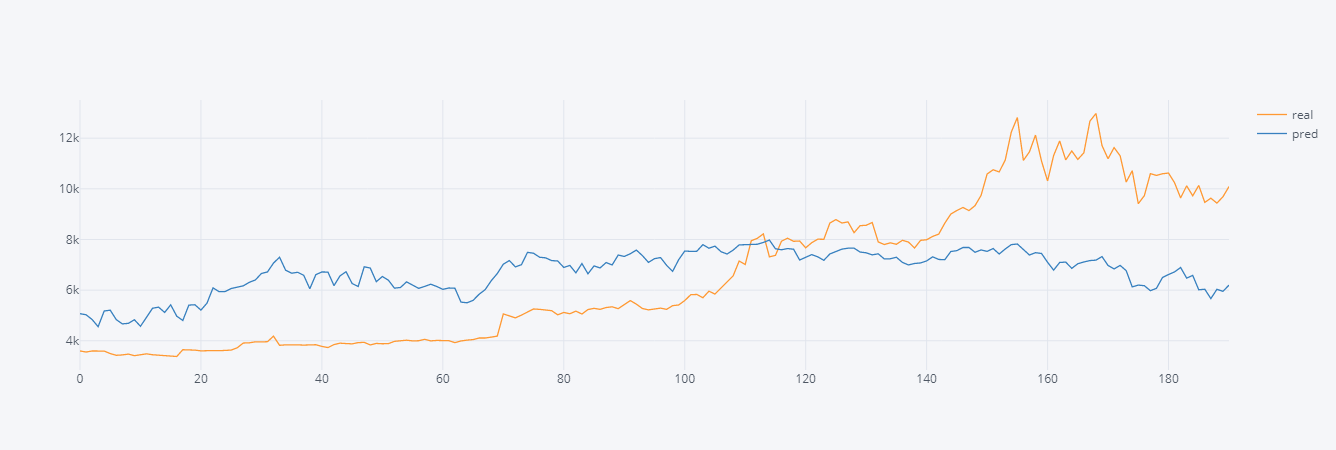

In [253]:
a.iplot()

In [258]:
from scipy.stats import pearsonr

In [280]:
pearsonr(sent1[1:], price[:-1])

(0.3630347705940253, 9.482162505549104e-14)

In [267]:
pearsonr(sent2, price)

(0.41894060791341375, 2.9184358099916867e-18)

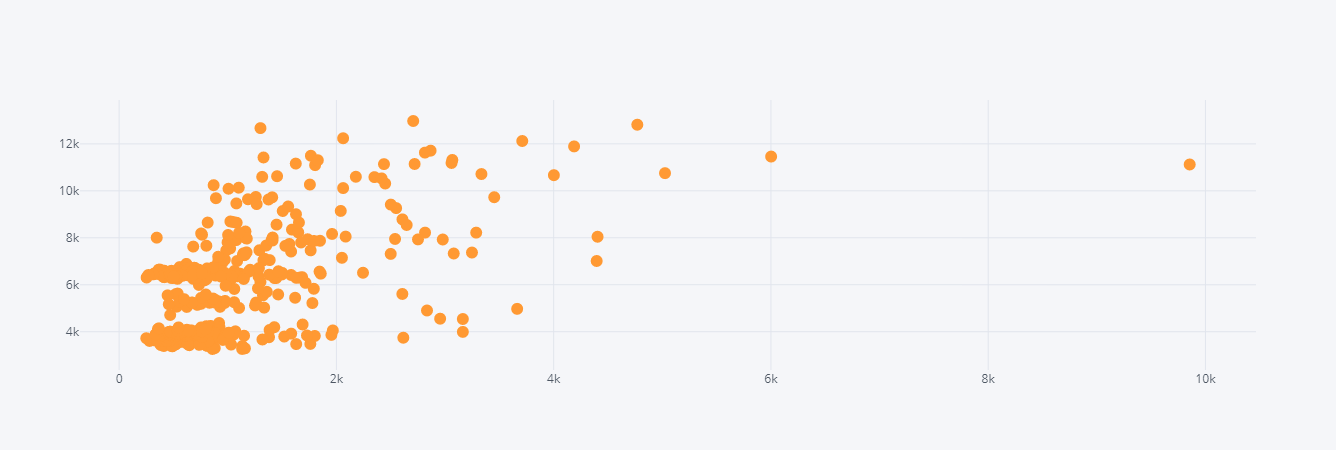

In [281]:
pd.DataFrame(price[1:], index=vol[:-1]).iplot(mode='markers')